In [66]:
import cv2
import numpy as np
from pdf2image import convert_from_path
from IPython.display import display, Image
import networkx as nx
import matplotlib.pyplot as plt

In [67]:
from pdfminer.high_level import extract_text

# pdf_path = "src/algebra_graph/part5_ideals.pdf"
pdf_path = 'src/algebra_graph/whole_textbook.pdf'

text = extract_text(pdf_path)
# with open("extracted_text_pdfminer.txt", "w", encoding="utf-8") as f:
#     f.write(text)

print("Text extraction complete!")

Text extraction complete!


In [68]:
def process_raw_text(text):
    text = text.replace('ﬁ', 'fi')
    return text

text = process_raw_text(text)

In [69]:
import string
valid_id_nums = string.digits + '.'

In [70]:
keywords = [
    'SECTION',
    'EXERCISES',

    'Definition',
    'Example',
    'Theorem',
    'Lemma',
    'Corollary',
    # 'Figure',
]

In [71]:
import re
keyword_indexes = [(k, m.start()) for k in keywords for m in re.finditer(k, text)]
keyword_indexes.sort(key=lambda x: x[1])

In [72]:
def iterate_forward_while_valid(text, keyword_start_idx, valid_chars, max_chars=10):
    digits = ''
    while text[keyword_start_idx] in valid_chars and len(digits) < max_chars:
        digits += text[keyword_start_idx]
        keyword_start_idx += 1

    return digits

In [73]:
def iterate_backward_while_valid(text, keyword_start_idx, valid_chars, max_chars=10):
    digits = ''
    while text[keyword_start_idx] in valid_chars and len(digits) < max_chars:
        digits += text[keyword_start_idx]
        keyword_start_idx -= 1

    return digits[::-1]

In [74]:
class Keyword:
    def __init__(self, keyword_type, id):
        self.keyword_type = keyword_type
        self.id = id

        self.chapter = int(id.split('.')[0])
        self.sub_id = int(id.split('.')[1])

    def __eq__(self, value):
        assert type(value) == Keyword
        return self.keyword_type == value.keyword_type and self.id == value.id
    
    def are_same_chapter(self, value):
        assert type(value) == Keyword
        return self.chapter == value.chapter
    
    def __repr__(self):
        return f'{self.keyword_type} {self.id}'
    
    def __hash__(self):
        return hash((self.keyword_type, self.chapter, self.sub_id))

In [75]:
from collections import OrderedDict, defaultdict

class OrderedDefaultDict(OrderedDict):
    def __init__(self, default_factory=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_factory = default_factory

    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        self[key] = value = self.default_factory()
        return value

    def append_to_last(self, value): # append to last value of type list
        if not self:
            raise IndexError("Cannot append to last: OrderedDefaultDict is empty.")
        last_key = next(reversed(self))
        self[last_key].append(value)

In [76]:
len(re.findall('SECTION', text))

53

In [77]:
section_num = None
id_count = 0

section_children = {}
section_keywords = []

for keyword, keyword_start_idx in keyword_indexes:
    if keyword == 'SECTION':
        section_num = iterate_forward_while_valid(text, keyword_start_idx + len(keyword), string.digits)
        section_num = int(section_num)
        id_count = 0

    elif keyword == 'EXERCISES':
        section_num = None
        id_count = 0

    elif section_num is not None:
        num = iterate_forward_while_valid(text, keyword_start_idx + len(keyword), string.digits, max_chars=2)
        num += iterate_forward_while_valid(text, keyword_start_idx + len(keyword) + len(num), '.', max_chars=1)
        num += iterate_forward_while_valid(text, keyword_start_idx + len(keyword) + len(num), string.digits, max_chars=2)

        if not num or num == '':
            num = iterate_backward_while_valid(text, keyword_start_idx - 1, string.digits, max_chars=2)
            num += iterate_backward_while_valid(text, keyword_start_idx - 1 - len(num), '.', max_chars=1)
            num += iterate_backward_while_valid(text, keyword_start_idx - 1 - len(num), string.digits, max_chars=2)
            num = '.'.join(num.split('.')[::-1])

        if num != '' and num != '.' and '.' in num:

            if section_num == 54 and num == '.20': # manually fixing mistakes in the PDF
                num = '20.6'

            keyword_object = Keyword(keyword, num)

            if keyword_object.chapter == section_num and keyword_object.sub_id > id_count:

                section_keywords.append(keyword_object)
                section_children[keyword_object] = []

                id_count = keyword_object.sub_id

            else:
                if keyword_object not in section_children[section_keywords[-1]] and keyword_object != section_keywords[-1]:
                    section_children[section_keywords[-1]].append(keyword_object)

In [79]:
section_children

{Definition 0.1: [],
 Definition 0.2: [Example 30.3],
 Definition 0.4: [],
 Example 0.5: [],
 Example 0.6: [],
 Definition 0.7: [],
 Example 0.8: [],
 Example 0.9: [],
 Definition 0.10: [],
 Example 0.11: [],
 Definition 0.12: [],
 Definition 0.13: [],
 Example 0.14: [],
 Definition 0.16: [],
 Example 0.17: [Definition 0.7],
 Definition 0.18: [],
 Example 0.19: [],
 Example 0.20: [Example 0.17],
 Example 0.21: [],
 Theorem 0.22: [],
 Example 1.2: [],
 Example 1.6: [Example 51.7],
 Example 1.9: [],
 Example 1.10: [],
 Example 1.11: [],
 Example 1.12: [],
 Example 1.13: [],
 Example 1.14: [],
 Example 1.15: [Definition 0.10, Example 0.11, Definition 0.4],
 Definition 2.1: [],
 Example 2.2: [],
 Example 2.3: [],
 Definition 2.4: [],
 Example 2.5: [],
 Example 2.6: [],
 Example 2.7: [],
 Example 2.8: [],
 Example 2.9: [],
 Example 2.10: [Example 2.8, Example 2.9, Definition 32.11],
 Definition 2.12: [Example 2.7],
 Theorem 2.13: [],
 Example 2.14: [],
 Example 2.16: [],
 Example 2.19: [],


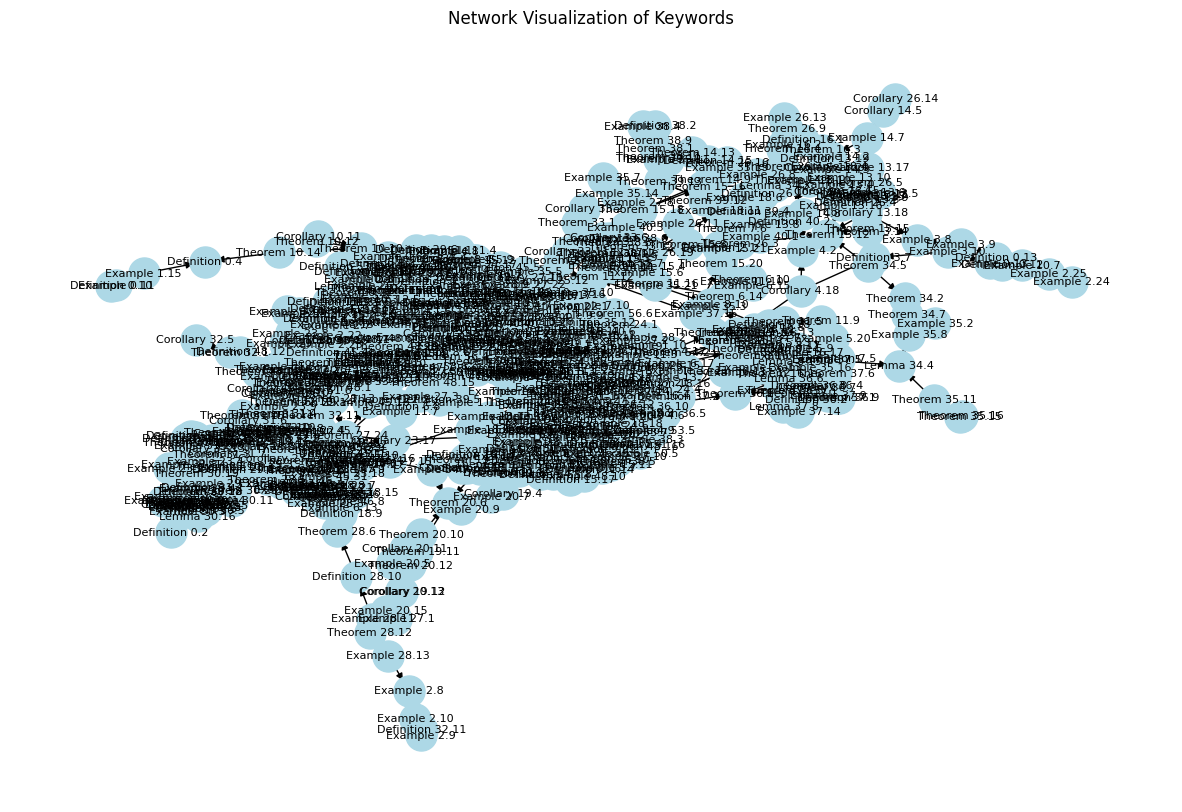

In [81]:
G = nx.DiGraph()

for parent, children in section_children.items():
    G.add_node(parent, type=parent.keyword_type, chapter=parent.chapter, sub_id=parent.sub_id)
    
    for child in children:
        G.add_node(child, type=child.keyword_type, chapter=child.chapter, sub_id=child.sub_id)
        G.add_edge(parent, child)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue")
nx.draw_networkx_edges(G, pos, arrows=True)

labels = {node: f"{node.keyword_type} {node.id}" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title("Network Visualization of Keywords")
plt.axis("off")
plt.show()

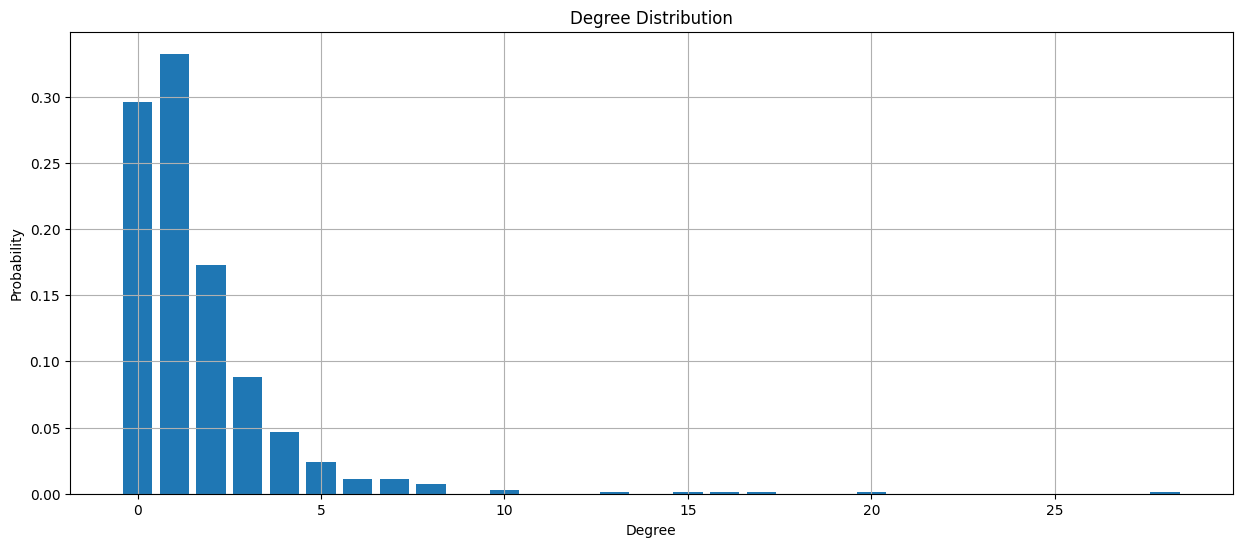

In [93]:
from collections import Counter

degrees = [degree for _, degree in G.degree()]
degree_counts = Counter(degrees)

total_nodes = len(G.nodes())
degree_distribution = {k: v / total_nodes for k, v in degree_counts.items()}

plt.figure(figsize=(15, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 2), align='left', rwidth=0.8, density=True)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

The shape of the degree distribution can reveal important characteristics about the graph:

a. **Random Graphs (Erdős–Rényi Model)**
- In random graphs, the degree distribution typically follows a **Poisson distribution**.
- Most nodes have a degree close to the average degree, with fewer nodes having very high or very low degrees.

b. **Scale-Free Networks**
- In scale-free networks, the degree distribution follows a power-law:
$$P(k)∼k^{−γ}$$
 
where P(k) is the probability of a node having degree k, and γ is a constant (typically between 2 and 3).
- These networks have a few highly connected "hub" nodes and many nodes with low degrees.

c. **Small-World Networks**
- Small-world networks often have a degree distribution that is somewhere between random and scale-free.
- They exhibit high clustering and short path lengths.

Fitted power-law parameters: C=1.00, gamma=2.00


/tmp/ipykernel_1456/2218665560.py:4: RuntimeWarning: divide by zero encountered in power
  return C * x ** (-gamma)
/tmp/ipykernel_1456/2218665560.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(power_law, x_data, y_data, p0=[1, 2])


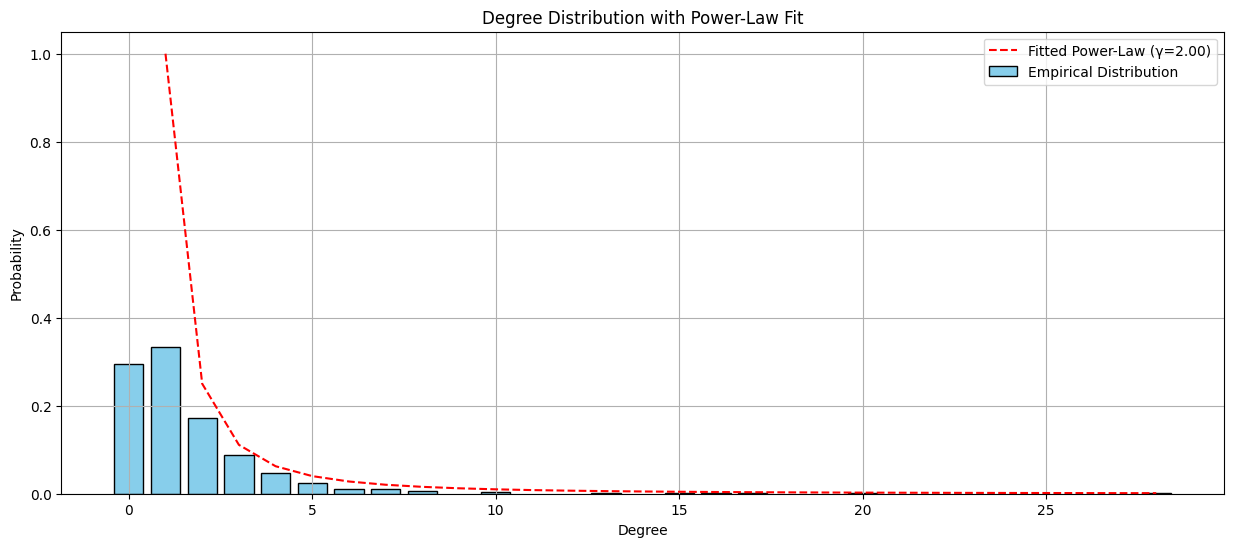

In [92]:
from scipy.optimize import curve_fit

def power_law(x, C, gamma):
    return C * x ** (-gamma)

sorted_degree_dist = sorted(degree_distribution.items())

x_data, y_data = zip(*sorted_degree_dist)

popt, _ = curve_fit(power_law, x_data, y_data, p0=[1, 2])
C, gamma = popt

print(f"Fitted power-law parameters: C={C:.2f}, gamma={gamma:.2f}")

x_fit = range(min(x_data), max(x_data) + 1)
y_fit = power_law(x_fit, C, gamma)

plt.figure(figsize=(15, 6))
plt.bar(x_data, y_data, color='skyblue', edgecolor='black', label="Empirical Distribution")
plt.plot(x_fit, y_fit, color='red', linestyle='--', label=f"Fitted Power-Law (γ={gamma:.2f})")
plt.title("Degree Distribution with Power-Law Fit")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)
plt.show()